In [2]:
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold ,KFold, train_test_split, cross_val_score, cross_val_predict
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,precision_recall_curve, roc_curve, roc_auc_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone, BaseEstimator

In [18]:
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]        
print(X.shape , y.shape)   # 70000 imagens com 28x28 pixels(784)

(70000, 784) (70000,)


In [9]:
X = X.to_numpy()
y = y.to_numpy()

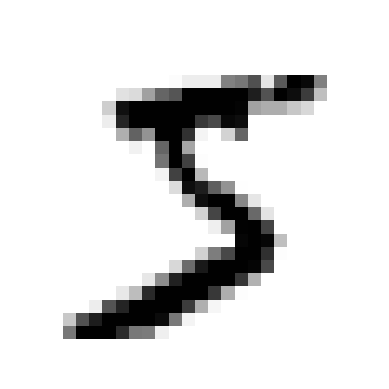

np.int64(5)

In [50]:
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y = y.astype(int)
y[0]

In [28]:
y_train_5 = (y_train == '5')  # True para todos os 5's, False para outros dígitos
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [37]:
guess = sgd_clf.predict([some_digit])
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(scores, guess)

[0.95035 0.96035 0.9604 ] [ True]


In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Confusion Matrix:
 [[53892   687]
 [ 1891  3530]]
Precision: 0.8371
Recall: 0.6512
F1-Score: 0.7325


In [40]:
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
    pass
 def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [41]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

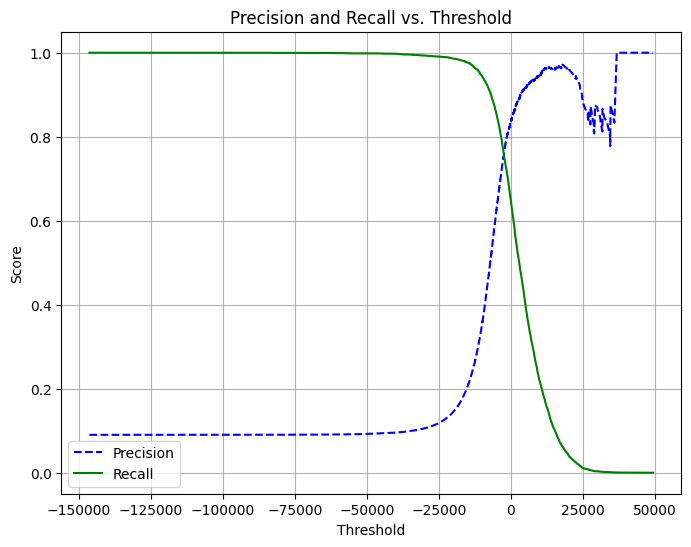

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
sgd_clf.fit(X_train_scaled, y_train_5)
y_scores = cross_val_predict(sgd_clf, X_train_scaled, y_train_5, cv=3, method="decision_function")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Threshold")
    plt.legend(loc="best")
    plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

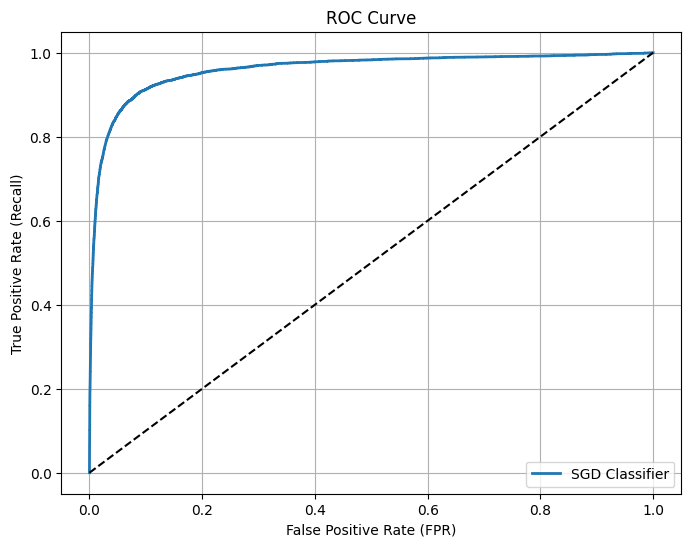

SGD Classifier ROC AUC Score: 0.9605


In [20]:
y_train_5 = (y[:60000] == 5)
y_test_5 = (y[60000:] == 5)
X_train, X_test = X[:60000], X[60000:]

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, "SGD Classifier")
plt.legend(loc="lower right")
plt.show()

# AUC score for SGDClassifier
roc_auc_sgd = roc_auc_score(y_train_5, y_scores)
print(f"SGD Classifier ROC AUC Score: {roc_auc_sgd:.4f}")

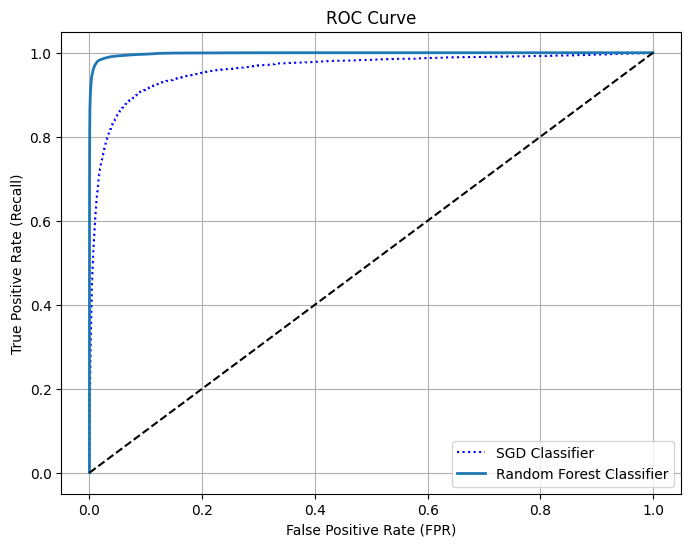

Random Forest Classifier ROC AUC Score: 0.9983


In [22]:
# Treinamento modelo Random Forest

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5)

# Get probabilities instead of decision scores
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Use the probabilities of the positive class to compute ROC curve
y_scores_forest = y_probas_forest[:, 1]  # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot ROC curve for RandomForestClassifier
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD Classifier")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest Classifier")
plt.legend(loc="lower right")
plt.show()

# AUC score for RandomForestClassifier
roc_auc_forest = roc_auc_score(y_train_5, y_scores_forest)
print(f"Random Forest Classifier ROC AUC Score: {roc_auc_forest:.4f}")

In [19]:
# Escalonar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

# Criar o classificador SGDClassifier
sgd_clf = OneVsRestClassifier(SGDClassifier(random_state=42))
sgd_clf.fit(X_train_scaled, y_train)

# Fazer uma previsão para um único dígito (o primeiro do conjunto de teste)
some_digit = X_test_scaled[0]
predicted_class = sgd_clf.predict([some_digit])
print(f'Classe predita do numero: {predicted_class}')

some_digit_scores = sgd_clf.decision_function([some_digit])
print(f'Scores de decisão para some_digit: {some_digit_scores}')
print(f'Classe predita: {sgd_clf.classes_[np.argmax(some_digit_scores)]}')

scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f'Accuracy (cross-validation): {scores}')
print(f'Average Accuracy: {scores.mean()}')

Classe predita do numero: [7]
Scores de decisão para some_digit: [[ -949.46098921 -1430.94893173 -1055.0107411   -355.10484317
   -948.53765327  -550.51382892 -1997.64457425   184.51270763
   -295.69944661  -152.026094  ]]
Classe predita: 7
Accuracy (cross-validation): [0.90015 0.89525 0.9055 ]
Average Accuracy: 0.9003
